<a href="https://colab.research.google.com/github/YLi999/RumorStanceClassification/blob/main/StanceClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install ktrain
!pip install ktrain

     |████████████████████████████████| 25.3MB 127kB/s 
     |████████████████████████████████| 983kB 50.0MB/s 
     |████████████████████████████████| 245kB 54.8MB/s 
     |████████████████████████████████| 1.1MB 51.1MB/s 
     |████████████████████████████████| 471kB 50.9MB/s 
     |████████████████████████████████| 3.0MB 54.4MB/s 
     |████████████████████████████████| 1.1MB 46.2MB/s 
     |████████████████████████████████| 890kB 50.6MB/s 
  Created wheel for ktrain: filename=ktrain-0.23.0-cp36-none-any.whl size=25271671 sha256=d0211e7bf9a2685c0f19456f53b65c777cd50efe8836cfc00e9c3c6f039ddaf3
  Stored in directory: /root/.cache/pip/wheels/f2/15/d1/ada9c041daebeb09b7341e2d3d0a765bf74e512edf2caa6fa7
  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34145 sha256=b445e645700c3d99ea0b5a5390cc0942e8405ca5ea6353a37dec5d5690430c05
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for lan

In [2]:
from google.colab import files
import pandas as pd
import numpy as np
import ktrain
from ktrain import text

In [5]:
# upload dataset
uploaded = files.upload()

Saving test.csv to test.csv


In [6]:
train_df = pd.read_csv('train.csv')
dev_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape[0], dev_df.shape[0], test_df.shape[0])

x_train = train_df[['text1', 'text2']].values
y_train = train_df['label'].values
x_dev = dev_df[['text1', 'text2']].values
y_dev = dev_df['label'].values
x_test = test_df[['text1', 'text2']].values
y_test = test_df['label'].values

# IMPORTANT: data format for sentence pair classification is list of tuples of form (str, str)
x_train = list(map(tuple, x_train))
x_dev = list(map(tuple, x_dev))
x_test = list(map(tuple, x_test))

4238 281 1049


In [7]:
print(x_train[0])
print(y_train[0])

('Question for <hashtag> police chief ? If officer <allcaps> darren <allcaps> wilson <allcaps> was in pursuit of a robbery suspect , why tell kids to get out of the road ? lie <allcaps>', '<user> <user> <user> This shows Michael paid for cigarillos . No robbery , no crime ! Pls rt <allcaps> <url>')
3


In [9]:
MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=256, class_names=[0,1,2,3])
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_dev, y_dev)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16) # lower bs if OOM occurs
#learner.lr_find()
#learner.fit_onecycle(5e-5, 4, class_weight = {0:1.259, 1:3.181, 2:3.210, 3:0.387})
learner.fit_onecycle(5e-5, 3)

preprocessing train...
language: en
sentence pairs detected


Is Multi-Label? False
preprocessing test...
language: en
sentence pairs detected




begin training using onecycle policy with max lr of 5e-05...
Epoch 1/3
265/265 [==============================] - 233s 878ms/step - loss: 0.9415 - accuracy: 0.6831 - val_loss: 0.7570 - val_accuracy: 0.7438
Epoch 2/3
265/265 [==============================] - 232s 876ms/step - loss: 0.7946 - accuracy: 0.7249 - val_loss: 0.7282 - val_accuracy: 0.7331
Epoch 3/3
265/265 [==============================] - 232s 875ms/step - loss: 0.6178 - accuracy: 0.7879 - val_loss: 0.6829 - val_accuracy: 0.7616


In [ ]:
#predictor.save('BERT_TM2')
#predictor = ktrain.load_predictor('/content/BERT_TM')

In [10]:
def adjust_prediction(prob):
  threshold = [0.198,0.078,0.077,0.645]
  predction = prob / threshold
  return np.argmax(predction, axis = 1)

In [11]:
predictor = ktrain.get_predictor(learner.model, t)
prediction_valid_prob = np.array(predictor.predict(x_dev, return_proba = True))
prediction_test_prob = np.array(predictor.predict(x_test, return_proba = True))
#prediction_valid = np.array(predictor.predict(x_dev))
#prediction_test = np.array(predictor.predict(x_test))
prediction_valid = adjust_prediction(prediction_valid_prob)
prediction_test = adjust_prediction(prediction_test_prob)
Y_dev = np.array(y_dev)
Y_test = np.array(y_test)

In [12]:
from sklearn.metrics import f1_score, fbeta_score, recall_score, confusion_matrix 
import seaborn as sns
import matplotlib.pyplot as plt
def evaluation(y_predict, y_valid, use_dev = False, use_2019 = False):
    
    s = np.array(4*[94])
    d = np.array(4*[71])
    q = np.array(4*[106])
    c = np.array(4*[778]) # for 2017 test data
	
    s1 = np.array(4*[69])
    d1 = np.array(4*[11])
    q1 = np.array(4*[28])
    c1 = np.array(4*[173]) # for 2017 dev data
	
    s2 = np.array(4*[141])
    d2 = np.array(4*[92])
    q2 = np.array(4*[62])
    c2 = np.array(4*[771]) # for 2019 test data
	
    if (use_dev == False) and (use_2019 == False):
        label_test_sum = np.array([s,d,q,c])
    elif (use_dev == False) and (use_2019 == True):
        label_test_sum = np.array([s2,d2,q2,c2])
    else:
        label_test_sum = np.array([s1,d1,q1,c1])
		
	
    weighted = np.array([0.4, 0.4, 0.15, 0.05])
    recall_each = recall_score(y_valid, y_predict, labels = [0,1,2,3], average = None)
    GMR = np.prod(recall_each)**(0.25)
    f2_score = fbeta_score(y_valid, y_predict, beta = 2, labels = [0,1,2,3], average=None)
    wFB =  np.dot(f2_score, weighted)
    macroF1 = f1_score(y_valid, y_predict, average = "macro")
    
    print("GMR is", GMR)
    print("wF2 is", wFB)
    print("macroF1 is", macroF1)
    
    sns.set()
    mat = confusion_matrix(y_valid, y_predict, labels = [0,1,2,3])
    mat = mat / label_test_sum
    label_name = ["support", "deny", "query", "comment"]
    fig = plt.figure()
    fig.add_subplot(1, 1, 1)
    sns.heatmap(mat, square=True, annot=True, cbar=True, xticklabels=label_name, yticklabels=label_name)
    plt.xlabel('prediction label')
    plt.ylabel('true label')

GMR is 0.6487969424214264
wF2 is 0.5344410209577777
macroF1 is 0.5579842067352827


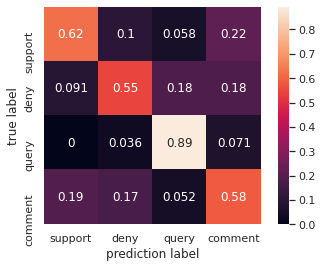

In [13]:
evaluation(prediction_valid, Y_dev, use_dev = True)

GMR is 0.633233349852955
wF2 is 0.5128816944189557
macroF1 is 0.5365847684026139


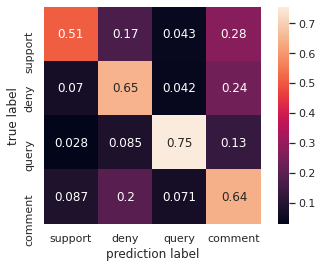

In [14]:
evaluation(prediction_test, Y_test, use_dev = False)